# **Predicting DoorDash Delivery ETA Model**
**by: Max Fukuhara, Jason Tran, Thomas McConnell, Michael Co, Dylan Chan**

**Motivation:**

*   As third-year college students, moving into off-campus housing meant cooking our own food but we all have days that we get lazy.
*    What's worse than being lazy and not having food? Ordering from DoorDash and it being late!


**About:**

*   We will be using a linear regression model to predict future DoorDash Delivery ETA times.

**Time Features:**
*   market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
*   created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
*   actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

**Store Features:**
*   store_id: an id representing the restaurant the order was submitted for
*   store_primary_category: cuisine category of the restaurant, e.g., italian, asian
*   order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Orders:**
*   total_items: total number of items in the order
*   subtotal: total value of the order submitted (in cents)
*   num_distinct_items: number of distinct items included in the order
*   min_item_price: price of the item with the least cost in the order (in cents)
*   max_item_price: price of the item with the highest cost in the order (in cents)


**Market Features**:
*   total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
*   total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
*   total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.



**Predictions from Other Models**:
*   estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
*   estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

# **Exploratory Data Analysis:**

**Importing Data:**

In [16]:
# import our data set
from datascience import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
url = 'https://drive.google.com/file/d/1kJdaBIFIngrKF9ldBYteI6ekTMjAGBCB/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)

First, let's verify the column names are same as data features mentioned in our about section above.

In [3]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

Next, we verify the shape of our data frame.

In [4]:
df.shape

(197428, 16)

Note that there are NaN values for some categories as well as values that do not make sense. We must do something about these values to properly begin with our data set.

In [5]:
# random sample of 20 rows
df.sample(20)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
193593,1.0,2015-01-31 02:25:07,2015-01-31 03:30:43,6743,chinese,1.0,14,8400,11,300,1400,25.0,25.0,33.0,446,807.0
5307,1.0,2015-02-13 22:54:51,2015-02-13 23:54:24,2549,sandwich,1.0,2,1390,2,395,995,4.0,4.0,11.0,446,539.0
166652,5.0,2015-02-01 00:30:50,2015-02-01 00:49:56,5462,salad,NaN,1,750,1,750,750,11.0,10.0,10.0,446,74.0
172078,4.0,2015-02-05 18:47:07,2015-02-05 20:17:23,4367,salad,2.0,12,12025,11,495,1375,33.0,30.0,27.0,251,511.0
114752,4.0,2015-01-31 03:00:22,2015-01-31 04:23:31,2896,thai,3.0,4,2498,2,250,999,91.0,89.0,185.0,251,645.0
16136,2.0,2015-01-24 22:21:42,2015-01-24 22:52:27,1311,american,3.0,2,2418,1,1209,1209,48.0,56.0,59.0,251,826.0
14138,1.0,2015-01-30 01:25:38,2015-01-30 02:18:42,6642,mexican,5.0,8,1790,4,50,650,32.0,33.0,42.0,251,261.0
104833,1.0,2015-01-29 01:19:49,2015-01-29 01:54:07,133,mediterranean,1.0,2,3748,2,599,2999,23.0,23.0,31.0,446,434.0
75245,2.0,2015-01-24 05:06:15,2015-01-24 05:51:23,5687,greek,5.0,3,3396,3,799,1199,24.0,33.0,56.0,251,223.0
177104,4.0,2015-01-30 00:16:16,2015-01-30 00:55:57,791,NaN,1.0,2,1998,2,699,999,39.0,15.0,15.0,446,608.0


**Finding Invalid Values:**


Let's first look at numerical data values.

In [6]:
df.select_dtypes('number').describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


Next, let's look at other NA values.

In [7]:
print(df.isnull().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


From this, there seems that there are some data values that intuitively do not make sense.

*  subtotal min is 0: could this mean that an order was discounted and free?
*  min_item_price min: -86 does not make sense... how could it be negative?
*  total_onshift_dashers min: -4 dashers does not make sense...
*  total_busy_dashers min: -5 dashers does not make sense...
*  total_outstanding_orders min: -6 orders does not make sense...
*  story_primary_category: there are NaN values for some categories

**Cleaning Invalid Values:**


We must now identify what to do with these invalid data values. Our choices would be to:
*   entirely remove entries that are negative (we must make sure we are not removing too many to make the data set very small)
*   replace with mean values
*   create our own category for NaN categorical values

In [8]:
df = df[df['min_item_price'] >= 0]
df = df[df['total_onshift_dashers'] >= 0]
df = df[df['total_busy_dashers'] >= 0]
df = df[df['total_outstanding_orders'] >= 0]
df = df.dropna()

In [9]:
# verify that there are no more negative values
df.select_dtypes('number').describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000,175687.000000
mean,2.744079,3556.498455,2.911860,3.204455,2697.182364,2.675041,684.980465,1160.195911,44.937127,41.878750,58.256337,307.800594,546.071821
std,1.330938,2055.948037,1.513078,2.672065,1828.680633,1.625620,519.802241,560.798759,34.542696,32.166493,52.730698,89.789257,218.712971
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1703.000000,1.000000,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,383.500000
50%,2.000000,3620.000000,3.000000,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,544.000000
75%,4.000000,5341.000000,4.000000,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,446.000000,703.000000
max,6.000000,6987.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


**Checking:** We must verify that there are not negative values and that there are no more entries with NaN.

In [10]:
remaining_negative_check = (df.select_dtypes(include=['number']) < 0).sum().sum() == 0
remaining_nan_check = df.isna().sum().sum() == 0

remaining_negative_check, remaining_nan_check

(True, True)

**Sanity Check:** We must make sure our data set did not shrink significantly.

In [11]:
df.shape

(175687, 16)

**Determining Predictor for Response Variable:**

First, we must create our target value column which is the delivery time.

In [13]:
# create target value  'delivery_time_seconds'
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_time_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

Next, we create do a correlational matrix in order to visualize which categories have the most impact on our target variable.

In [14]:
# select only numerical columns for correlation analysis
numeric_cols = df.select_dtypes(include=['number'])

# calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# focus on correlations with 'delivery_time_seconds'
correlation_with_delivery_time = correlation_matrix['delivery_time_seconds'].sort_values(ascending=False)

Finally, let's visualize this as a heatmap to see each correlation.

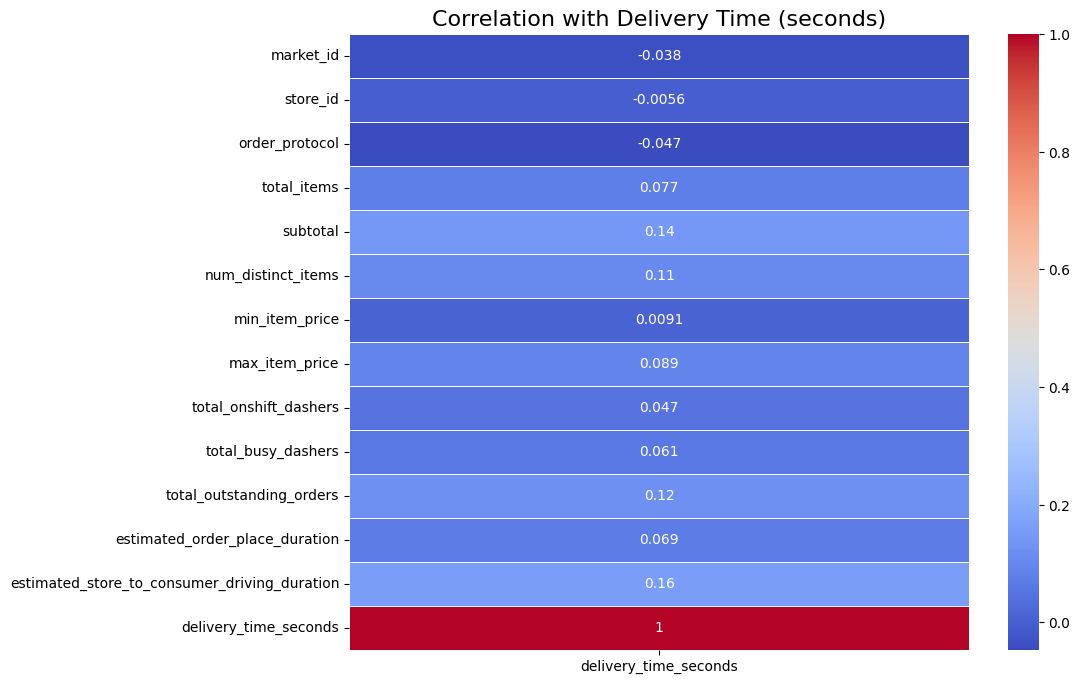

In [15]:
# plot a heatmap to visualize correlations with 'delivery_time_seconds'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['delivery_time_seconds']], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation with Delivery Time (seconds)', fontsize=16)
plt.show()

**Notes:**

The correlation values are relatively low, indicating that these features have a weak relationship with delivery time. However, total_outstanding_orders has the strongest correlation, meaning that when more orders are outstanding, delivery time tends to increase.